###**SimCLR Simple Contrastive Learning of Visual Representations self-supervised learning algorithm**

In [ ]:
pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.models as models
import torchvision
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import timm

In [ ]:
model = model.cuda()

In [ ]:
# Define data augmentations
augmentation = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2)
])

# Define tensor transformation
tensor_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
full_train_dataset = CIFAR10(root="./data", train=True, download=True, transform=tensor_transform)
full_test_dataset = CIFAR10(root="./data", train=False, download=True, transform=tensor_transform)

num_classes = 10
# Create a subset of the training dataset (10 images per class)
train_subset_indices = []
for class_idx in range(num_classes):
    class_indices = [idx for idx, label in enumerate(full_train_dataset.targets) if label == class_idx]
    train_subset_indices.extend(class_indices[:2000])
train_dataset = Subset(full_train_dataset, train_subset_indices)

# Create a subset of the test dataset (10 images per class)
test_subset_indices = []
for class_idx in range(num_classes):
    class_indices = [idx for idx, label in enumerate(full_test_dataset.targets) if label == class_idx]
    test_subset_indices.extend(class_indices[:500])
test_dataset = Subset(full_test_dataset, test_subset_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Define ResNet-18 encoder
class ResNetEncoder(nn.Module):
    def __init__(self):
        super(ResNetEncoder, self).__init__()
        self.encoder = torchvision.models.resnet18(pretrained=False)
        self.encoder.fc = nn.Identity()  # Replace the last fully connected layer

    def forward(self, x):
        x = self.encoder(x)
        return x

# Define SimCLR model
class SimCLR(nn.Module):
    def __init__(self, encoder, feature_dim=128):  # Specify the desired feature dimension
        super(SimCLR, self).__init__()
        self.encoder = encoder
        self.projector = nn.Sequential(
            nn.Linear(512, feature_dim),  # Adjust the output size of the projection head
            nn.ReLU(),
            nn.Linear(feature_dim, feature_dim)  # Adjust the output size of the projection head
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.projector(x)
        return x

# Define contrastive loss
def contrastive_loss(features):
    features = nn.functional.normalize(features, dim=1)
    similarity_matrix = torch.matmul(features, features.T)
    batch_size = similarity_matrix.shape[0] // 2
    mask = torch.eye(batch_size * 2, dtype=torch.bool).to(similarity_matrix.device)  # Adjust the mask size
    similarity_matrix = similarity_matrix.masked_fill(mask, -9e15)
    positive_mask = torch.diagonal(similarity_matrix, offset=batch_size)
    negative_mask = similarity_matrix[~mask].view(batch_size, -1)
    positive_logits = positive_mask.unsqueeze(-1)
    negative_logits = negative_mask
    logits = torch.cat([positive_logits, negative_logits], dim=-1)
    labels = torch.zeros(batch_size, dtype=torch.long).to(logits.device)
    loss = nn.functional.cross_entropy(logits, labels)
    return loss

In [ ]:
# Initialize model and optimizer
encoder = ResNetEncoder()
model = SimCLR(encoder)
model = model.cuda()  # Move the model to GPU
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
train_losses = []
train_accuracies = []
train_top1_accuracies = []
train_top3_accuracies = []

for epoch in range(100):
    running_loss = 0.0
    correct = 0
    top1_correct = 0
    top3_correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images = images.cuda(non_blocking=True)
        images1 = augmentation(images)
        images2 = augmentation(images)
        features1 = model(images1)
        features2 = model(images2)
        features = torch.cat([features1, features2], dim=0)
        loss = contrastive_loss(features)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Evaluation
        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.cuda()).sum().item()

            # Top-1 accuracy
            top1_accuracy = (predicted == labels.cuda()).float().sum() / labels.size(0)
            top1_correct += top1_accuracy.item()

            # Top-3 accuracy
            _, top3_predictions = outputs.topk(3, 1, True, True)
            top3_accuracy = torch.any(top3_predictions == labels.cuda().view(-1, 1), dim=1).float().sum() / labels.size(0)
            top3_correct += top3_accuracy.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100.0 * correct / total
    epoch_top1_accuracy = 100.0 * top1_correct / len(train_loader)
    epoch_top3_accuracy = 100.0 * top3_correct / len(train_loader)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    train_top1_accuracies.append(epoch_top1_accuracy)
    train_top3_accuracies.append(epoch_top3_accuracy)

    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Top-1 Accuracy: {epoch_top1_accuracy:.2f}%, Top-3 Accuracy: {epoch_top3_accuracy:.2f}%")

100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Epoch 1, Loss: 6.4762, Accuracy: 0.85%, Top-1 Accuracy: 0.85%, Top-3 Accuracy: 1.85%


100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Epoch 2, Loss: 6.3885, Accuracy: 1.25%, Top-1 Accuracy: 1.25%, Top-3 Accuracy: 2.47%


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Epoch 3, Loss: 6.3288, Accuracy: 1.28%, Top-1 Accuracy: 1.28%, Top-3 Accuracy: 2.69%


100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


Epoch 4, Loss: 6.3414, Accuracy: 1.13%, Top-1 Accuracy: 1.13%, Top-3 Accuracy: 2.67%


100%|██████████| 78/78 [00:18<00:00,  4.27it/s]


Epoch 5, Loss: 6.3085, Accuracy: 1.01%, Top-1 Accuracy: 1.01%, Top-3 Accuracy: 2.25%


100%|██████████| 78/78 [00:19<00:00,  4.04it/s]


Epoch 6, Loss: 6.3019, Accuracy: 1.10%, Top-1 Accuracy: 1.10%, Top-3 Accuracy: 2.94%


100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


Epoch 7, Loss: 6.3208, Accuracy: 0.42%, Top-1 Accuracy: 0.42%, Top-3 Accuracy: 1.66%


100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


Epoch 8, Loss: 6.3216, Accuracy: 0.64%, Top-1 Accuracy: 0.64%, Top-3 Accuracy: 2.41%


100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


Epoch 9, Loss: 6.3064, Accuracy: 0.33%, Top-1 Accuracy: 0.33%, Top-3 Accuracy: 1.47%


100%|██████████| 78/78 [00:19<00:00,  4.08it/s]


Epoch 10, Loss: 6.3129, Accuracy: 0.30%, Top-1 Accuracy: 0.30%, Top-3 Accuracy: 1.93%


100%|██████████| 78/78 [00:18<00:00,  4.21it/s]


Epoch 11, Loss: 6.2707, Accuracy: 0.20%, Top-1 Accuracy: 0.20%, Top-3 Accuracy: 1.76%


100%|██████████| 78/78 [00:18<00:00,  4.21it/s]


Epoch 12, Loss: 6.3096, Accuracy: 0.29%, Top-1 Accuracy: 0.29%, Top-3 Accuracy: 1.88%


100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Epoch 13, Loss: 6.2977, Accuracy: 0.21%, Top-1 Accuracy: 0.21%, Top-3 Accuracy: 1.62%


100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


Epoch 14, Loss: 6.2898, Accuracy: 0.22%, Top-1 Accuracy: 0.22%, Top-3 Accuracy: 1.50%


100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


Epoch 15, Loss: 6.3075, Accuracy: 0.22%, Top-1 Accuracy: 0.22%, Top-3 Accuracy: 1.61%


100%|██████████| 78/78 [00:19<00:00,  3.99it/s]


Epoch 16, Loss: 6.2637, Accuracy: 0.30%, Top-1 Accuracy: 0.30%, Top-3 Accuracy: 1.70%


100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Epoch 17, Loss: 6.2421, Accuracy: 0.28%, Top-1 Accuracy: 0.28%, Top-3 Accuracy: 1.29%


100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Epoch 18, Loss: 6.2922, Accuracy: 0.48%, Top-1 Accuracy: 0.48%, Top-3 Accuracy: 1.69%


100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Epoch 19, Loss: 6.2923, Accuracy: 0.47%, Top-1 Accuracy: 0.47%, Top-3 Accuracy: 2.15%


100%|██████████| 78/78 [00:18<00:00,  4.18it/s]


Epoch 20, Loss: 6.2911, Accuracy: 0.34%, Top-1 Accuracy: 0.34%, Top-3 Accuracy: 1.50%


100%|██████████| 78/78 [00:18<00:00,  4.33it/s]


Epoch 21, Loss: 6.2750, Accuracy: 0.55%, Top-1 Accuracy: 0.55%, Top-3 Accuracy: 1.77%


100%|██████████| 78/78 [00:19<00:00,  4.05it/s]


Epoch 22, Loss: 6.2504, Accuracy: 0.42%, Top-1 Accuracy: 0.42%, Top-3 Accuracy: 1.82%


100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Epoch 23, Loss: 6.2441, Accuracy: 0.47%, Top-1 Accuracy: 0.47%, Top-3 Accuracy: 1.51%


100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


Epoch 24, Loss: 6.2885, Accuracy: 0.38%, Top-1 Accuracy: 0.38%, Top-3 Accuracy: 1.23%


100%|██████████| 78/78 [00:18<00:00,  4.31it/s]


Epoch 25, Loss: 6.2631, Accuracy: 0.39%, Top-1 Accuracy: 0.39%, Top-3 Accuracy: 1.32%


100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


Epoch 26, Loss: 6.2472, Accuracy: 0.51%, Top-1 Accuracy: 0.51%, Top-3 Accuracy: 1.65%


100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Epoch 27, Loss: 6.2849, Accuracy: 0.62%, Top-1 Accuracy: 0.62%, Top-3 Accuracy: 1.88%


100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


Epoch 28, Loss: 6.2401, Accuracy: 0.65%, Top-1 Accuracy: 0.65%, Top-3 Accuracy: 2.04%


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Epoch 29, Loss: 6.2223, Accuracy: 0.42%, Top-1 Accuracy: 0.42%, Top-3 Accuracy: 1.27%


100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


Epoch 30, Loss: 6.2755, Accuracy: 0.37%, Top-1 Accuracy: 0.37%, Top-3 Accuracy: 1.35%


100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


Epoch 31, Loss: 6.2235, Accuracy: 0.46%, Top-1 Accuracy: 0.46%, Top-3 Accuracy: 1.62%


100%|██████████| 78/78 [00:19<00:00,  4.00it/s]


Epoch 32, Loss: 6.2280, Accuracy: 0.51%, Top-1 Accuracy: 0.51%, Top-3 Accuracy: 1.66%


100%|██████████| 78/78 [00:19<00:00,  4.03it/s]


Epoch 33, Loss: 6.2495, Accuracy: 0.54%, Top-1 Accuracy: 0.54%, Top-3 Accuracy: 1.55%


100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


Epoch 34, Loss: 6.2625, Accuracy: 0.53%, Top-1 Accuracy: 0.53%, Top-3 Accuracy: 1.56%


100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


Epoch 35, Loss: 6.2299, Accuracy: 0.49%, Top-1 Accuracy: 0.49%, Top-3 Accuracy: 1.57%


100%|██████████| 78/78 [00:17<00:00,  4.43it/s]


Epoch 36, Loss: 6.2384, Accuracy: 0.33%, Top-1 Accuracy: 0.33%, Top-3 Accuracy: 1.45%


100%|██████████| 78/78 [00:17<00:00,  4.35it/s]


Epoch 37, Loss: 6.2644, Accuracy: 0.36%, Top-1 Accuracy: 0.36%, Top-3 Accuracy: 1.28%


100%|██████████| 78/78 [00:19<00:00,  4.06it/s]


Epoch 38, Loss: 6.2504, Accuracy: 0.34%, Top-1 Accuracy: 0.34%, Top-3 Accuracy: 1.16%


100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


Epoch 39, Loss: 6.2367, Accuracy: 0.36%, Top-1 Accuracy: 0.36%, Top-3 Accuracy: 1.15%


100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Epoch 40, Loss: 6.2197, Accuracy: 0.44%, Top-1 Accuracy: 0.44%, Top-3 Accuracy: 1.43%


100%|██████████| 78/78 [00:18<00:00,  4.21it/s]


Epoch 41, Loss: 6.2149, Accuracy: 0.50%, Top-1 Accuracy: 0.50%, Top-3 Accuracy: 1.55%


100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Epoch 42, Loss: 6.2219, Accuracy: 0.40%, Top-1 Accuracy: 0.40%, Top-3 Accuracy: 1.40%


100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


Epoch 43, Loss: 6.2214, Accuracy: 0.47%, Top-1 Accuracy: 0.47%, Top-3 Accuracy: 1.33%


100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Epoch 44, Loss: 6.2203, Accuracy: 0.34%, Top-1 Accuracy: 0.34%, Top-3 Accuracy: 1.19%


100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Epoch 45, Loss: 6.2266, Accuracy: 0.36%, Top-1 Accuracy: 0.36%, Top-3 Accuracy: 1.31%


100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


Epoch 46, Loss: 6.2203, Accuracy: 0.50%, Top-1 Accuracy: 0.50%, Top-3 Accuracy: 1.44%


100%|██████████| 78/78 [00:19<00:00,  4.09it/s]


Epoch 47, Loss: 6.2500, Accuracy: 0.30%, Top-1 Accuracy: 0.30%, Top-3 Accuracy: 1.20%


100%|██████████| 78/78 [00:18<00:00,  4.14it/s]


Epoch 48, Loss: 6.2184, Accuracy: 0.33%, Top-1 Accuracy: 0.33%, Top-3 Accuracy: 1.20%


100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


Epoch 49, Loss: 6.2266, Accuracy: 0.33%, Top-1 Accuracy: 0.33%, Top-3 Accuracy: 1.36%


100%|██████████| 78/78 [00:18<00:00,  4.19it/s]

Epoch 50, Loss: 6.2220, Accuracy: 0.47%, Top-1 Accuracy: 0.47%, Top-3 Accuracy: 1.55%


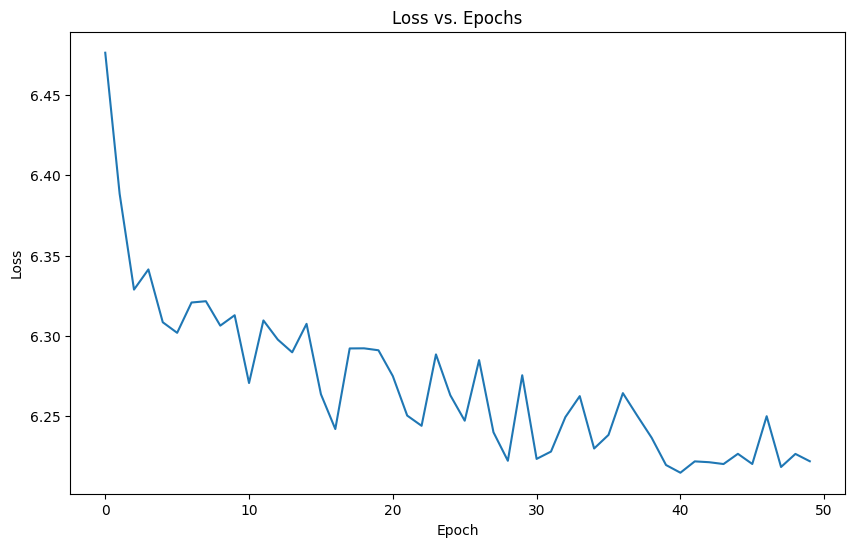

In [ ]:
# Plot loss vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.show()

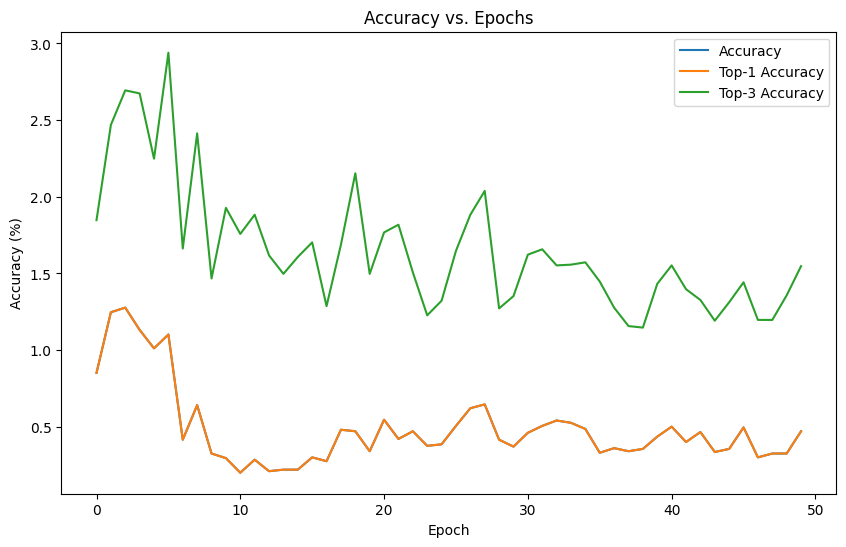

In [ ]:
# Plot accuracy vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label="Accuracy")
plt.plot(train_top1_accuracies, label="Top-1 Accuracy")
plt.plot(train_top3_accuracies, label="Top-3 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Epochs")
plt.legend()
plt.show()